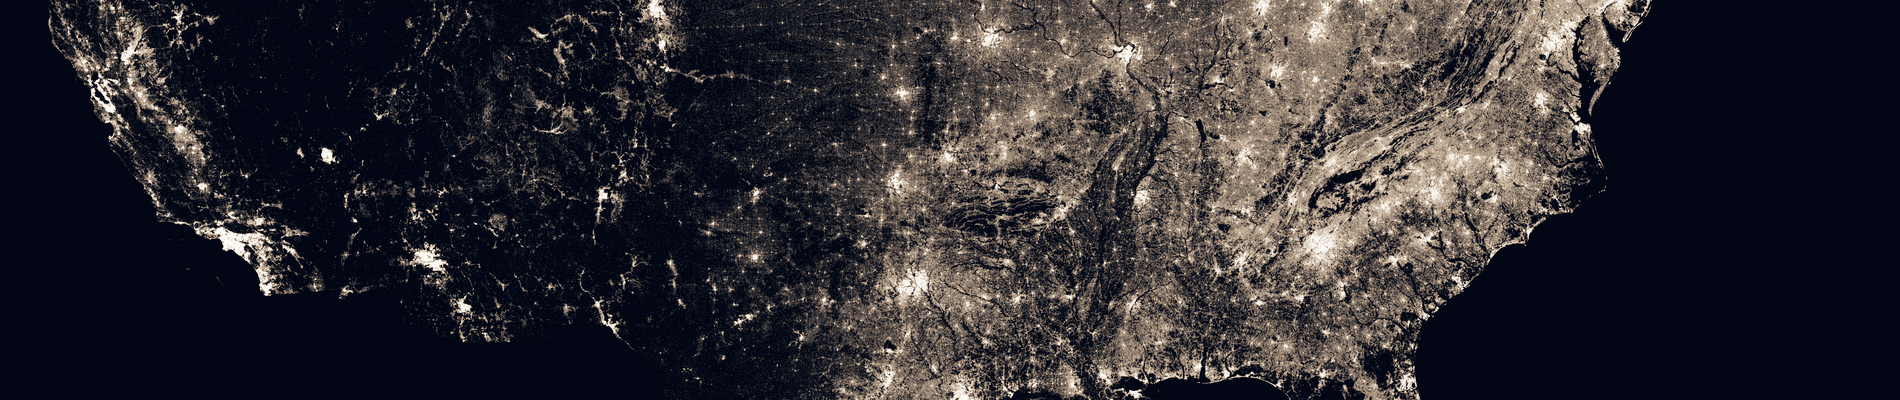
# 🤗 SentenceTransformer, RAPIDS cuML TfidfVectorizer and KNN to find duplicate locations
In this notebook, we use SentenceTransformer from Hugging Face in combination with RAPIDS cuML's TfidfVectorizer and cuML's KNN to find locations with similar names and categories and nearby geographic coordinates. First, we use RAPIDS cuML TfidfVectorizer to extract text embeddings of each location's name and then compare the embeddings using RAPIDS cuML KNN. Next, we extract text embeddings of each location's category with 🤗 SentenceTransformer and compare them using RAPIDS cuML KNN. Finally, we search the nearby points of each location by comparing geographic coordinates using RAPIDS cuML KNN.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load train data
In this competition, we have locations with geographic coordinates and several text features. For the train data, the column `point_of_interest` indicates the ground truth of which locations describe the same point-of-interest (POI). We need to build a model that finds entries describing a common POI based on the available text and numerical features. In this notebook, we explore some tools to help us in this process.

In [ ]:
train = pd.read_csv('../input/foursquare-location-matching/train.csv')
print('train shape is', train.shape)
train.head()

As we can see, the training set has eleven attribute fields for over one million place entries, together with `id`, a unique identifier for each entry, and `point_of_interest`, an identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two or more entries match when they describe a common POI. Also, it was confirmed by the host that the places in the train and test data do not overlap, so **we only need to find matches within the test data**.
# Display duplicate locations from train data
Using the column `point_of_interest` which is the ground truth, we can display examples of duplicate items describing the same POI. As we can see there are many POIs that appear one or very few times, while there are very few POIs that have a lot of duplicates.

In [ ]:
groups = train.point_of_interest.value_counts()
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(groups)), groups.values)
plt.ylabel('Duplicate Count', size=14)
plt.xlabel('Index of Unique POI', size=14)
plt.title('Duplicate Count vs. Unique POI Count', size=16)
plt.show()

plt.figure(figsize=(20,5))
plt.bar(groups.index.values[:50].astype('str'), groups.values[:50])
plt.xticks(rotation=45)
plt.ylabel('Duplicate Count', size=14)
plt.xlabel('Label Group', size=14)
plt.title('Top 50 Duplicated POIs', size=16)
plt.show()

In [ ]:
for k in range(5):
    print('#'*50)
    print('### TOP %i DUPLICATED POIs:'%(k+1), groups.index[k])
    print('#'*50)
    top = train.loc[train.point_of_interest==groups.index[k]]
    print(top.head())

# Find similar names with RAPIDS!
We will now ignore the ground truth and try to find similar locations in train data using only the text in the `name` column. First, we will extract text embeddings using RAPIDS cuML's TfidfVectorizer. This will turn every location name into a high-dimensional vectorial representation of the words present. We will then compare the resulting vectors with RAPIDS cuML KNN to find names that are similar.

In [ ]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
print('RAPIDS', cuml.__version__)

In [ ]:
# load train data unto the gpu with cudf
train_gf = cudf.read_csv('../input/foursquare-location-matching/train.csv')
print('train_gf shape is', train_gf.shape)
train_gf.head()

## Extract text embeddings with RAPIDS TfidfVectorizer
[TfidfVectorizer](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a common tool widely used in information retrieval systems. It takes into account the frequency of a term in a sentence along with its presence in the entire collection. RAPIDS TfidfVectorizer returns a very large cupy sparse matrix that normally wouldn't fit in the GPU’s memory if it was in its dense form. This is why it is very important to handle sparsity for TfidfVectorizer. Afterwards, we feed that sparse matrix into RAPIDS cuML KNN.

In [ ]:
model = TfidfVectorizer()
name_embeddings = model.fit_transform(train_gf.name)
print('name_embeddings shape is', name_embeddings.shape)

## Find similar names with RAPIDS KNN
After fitting KNN, we will display some example rows of train and their 10 closest other location names in train based on the TFIDF vectorial representation. We retrieve the closest neighbors only for the first thousand rows as this is only to show the method, otherwise running KNN on such a large matrix takes a few minutes even for cuML (but it's more than a reasonable time given what we're asking it to do).

In [ ]:
KNN = 50
model = NearestNeighbors(n_neighbors=KNN, metric='cosine')
model.fit(name_embeddings)
# only for the first 1000 rows
distances, indices = model.kneighbors(name_embeddings[:1000])

In [ ]:
for k in [1, 3, 4, 89, 232]:
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50), cupy.asnumpy(distances[k,]),'o-')
    plt.title('Name Distance From Train Row %i to Other Train Rows'%k, size=16)
    plt.ylabel('Distance to Train Row %i'%k, size=14)
    plt.xlabel('Index Sorted by Distance to Train Row %i'%k, size=14)
    plt.show()
    
    print(train_gf.loc[cupy.asnumpy(indices[k,:10]), ['name','point_of_interest']])

We see that this easily detects some duplicates, but shows a whole other set of problems such as the difficulty in distinguishing the names of chain stores with different outlets or encoding characters in other languages than English.
# Find similar categories with RAPIDS and 🤗!
We will now ignore the ground truth and try to find similar locations in train data using only the text in the `categories` column. First, we will extract text embeddings using [SentenceTransformer](https://huggingface.co/sentence-transformers) from Hugging Face, a super simple and versatile framework for sentence embeddings (and more) with few lines of code. SentenceTransformer might work better in this case because we are not interested in keeping every detail of a name like with TfidfVectorizer, but rather we want to extract the contextual meaning of a description. Furthermore, it's such a useful tool that it makes sense to introduce it. We will then compare text embeddings with RAPIDS cuML KNN to find categories that are similar.
## Extract text embeddings with Hugging Face SentenceTransformer

In [ ]:
!pip install -q sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
# sentences are encoded just by calling model.encode()
cat_embeddings = model.encode(train.categories.fillna('nocategory'), batch_size=128)
print('cat_embeddings shape is', cat_embeddings.shape)

## Find similar categories with RAPIDS KNN
After fitting KNN, we will display some example rows of train and their 10 closest other location names in train based on the SentenceTransformer vectorial representation of the `categories` column. Again, we retrieve the closest neighbors only for the first thousand rows just to see the results and also to avoid memory errors since the matrix here is not sparse.

In [ ]:
KNN = 50
model = NearestNeighbors(n_neighbors=KNN, metric='cosine')
model.fit(cat_embeddings)
# only for the first 1000 rows
distances, indices = model.kneighbors(cat_embeddings[:1000])

In [ ]:
for k in [77, 94, 95, 128, 168]:
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50), cupy.asnumpy(distances[k,]),'o-')
    plt.title('Category Distance From Train Row %i to Other Train Rows'%k, size=16)
    plt.ylabel('Distance to Train Row %i'%k, size=14)
    plt.xlabel('Index Sorted by Distance to Train Row %i'%k, size=14)
    plt.show()
    
    print(train_gf.loc[cupy.asnumpy(indices[k,:10]), ['categories','point_of_interest']])

Again we see this works as expected, but also might provide a lot of false matches since the categories are shared across different commercial activities and locations and are often less discriminative than the name of a place.
# Find nearby geographic locations with RAPIDS KNN!
Lastly, we will ignore the ground truth and try to find similar locations in train data using only the two geographic coordinates, which is the most natural thing to do. RAPIDS cuML KNN will find nearby points blazing fast in this million-row dataset!

In [ ]:
coord_cols = ['latitude', 'longitude']
KNN = 50
model = NearestNeighbors(n_neighbors=KNN)
model.fit(train[coord_cols])
# now we do it for all data
distances, indices = model.kneighbors(train[coord_cols])

In [ ]:
for k in [177, 398, 437, 594, 911]:
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50), cupy.asnumpy(distances[k,]),'o-')
    plt.title('Geographic Distance From Train Row %i to Other Train Rows'%k, size=16)
    plt.ylabel('Distance to Train Row %i'%k, size=14)
    plt.xlabel('Index Sorted by Distance to Train Row %i'%k, size=14)
    plt.show()
    
    print(train_gf.loc[cupy.asnumpy(indices[k,:10]), ['latitude', 'longitude', 'point_of_interest']])

Unsurprisingly, geographic coordinates work very well. After all, we are talking about finding places on the globe and the distance between them is the first discriminator, at least at the highest level.
# Metric
The metric for this competition is the mean [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU, aka the Jaccard index) of the ground-truth entry matches $T$ and the predicted entry matches $P$, with the mean taken sample-wise. In other words, an IoU score is calculated for each row in the submission file, and the final score is their average. The Jaccard index is a quantity bounded between 0 and 1 and clearly higher is better! Remember that in this competition **places always self-match**.

$$J(P, T) = \frac{|P \cap T|}{|P \cup T|}$$
# Test data
The next thing to do is try applying the above methods to the test data and create a submission notebook! There is also plenty of creative feature engineering and modeling to do, as clearly the best results will be obtained by combining all the available information and dynamically adjusting the importance of each based on the others. For example, it might be crucial to look at the name and category for locations in the same city or even district, but those might not be too important if two locations are really far away. Have fun and keep exploring the data!

In [ ]:
test = pd.read_csv('../input/foursquare-location-matching/test.csv')
print(test.shape)
test.head()

In [ ]:
sub = pd.read_csv('../input/foursquare-location-matching/sample_submission.csv')
print(sub.shape)
sub.head()